## Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.

In [52]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

## Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

In [3]:
cols_to_model = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value',
'ocean_proximity']

In [4]:
df = df[cols_to_model]

In [6]:
df= df.fillna(0)
df.isnull().sum()

In [8]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
cols_to_train = ['latitude',
 'longitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [14]:
train_dicts = df_train[cols_to_train].to_dict(orient='records')
val_dicts = df_val[cols_to_train].to_dict(orient='records')

In [16]:
dict_vect = DictVectorizer(sparse=False)

X_train = dict_vect.fit_transform(train_dicts)
X_val = dict_vect.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`  **Answer**
* `total_rooms`
* `latitude`
* `population`

In [18]:
model_dt = DecisionTreeRegressor(max_depth=1)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [21]:
print(export_text(model_dt, feature_names=dict_vect.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/elite/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* **0.25**
* 0.55
* 0.85

In [23]:
model_rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [25]:
y_pred = model_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.24566012875324933


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **150**

In [30]:
estimator_list = []
rmse_list = []
for estimator in range(10, 210, 10):
    estimator_list.append(estimator)
    model_rf = RandomForestRegressor(n_estimators=estimator,random_state=1,n_jobs=-1)
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_val)
    rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

df_rmse = pd.DataFrame(zip(estimator_list, rmse_list), columns=['Estimator', 'RMSE'])
    
    

In [37]:
df_rmse[df_rmse['RMSE'] == df_rmse['RMSE'].min()]

,Estimator,RMSE
16,170,0.231432


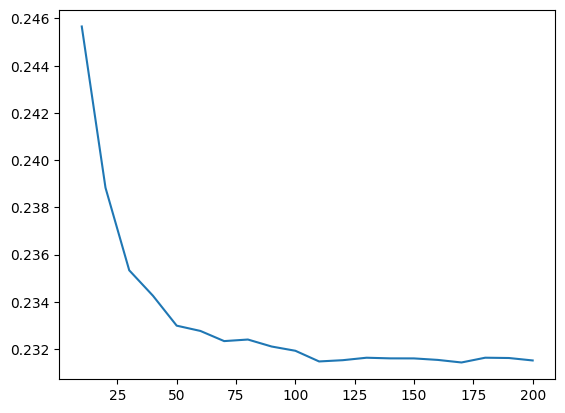

In [34]:
plt.plot(df_rmse['Estimator'], df_rmse['RMSE'])

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* **25**

In [40]:
estimator_list = []
rmse_list = []
depth_list = []
for depth in [10, 15, 20, 25]:
    
    for estimator in range(10, 210, 10):
        depth_list.append(depth)
        estimator_list.append(estimator)
        model_rf = RandomForestRegressor(n_estimators=estimator,max_depth=depth, random_state=1,n_jobs=-1)
        model_rf.fit(X_train, y_train)
        y_pred = model_rf.predict(X_val)
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        print(depth, estimator)

df_rmse_depth = pd.DataFrame(zip(depth_list, estimator_list, rmse_list), columns=['Depth','Estimator', 'RMSE'])
    

10 10
10 20
10 30
10 40
10 50
10 60
10 70
10 80
10 90
10 100
10 110
10 120
10 130
10 140
10 150
10 160
10 170
10 180
10 190
10 200
15 10
15 20
15 30
15 40
15 50
15 60
15 70
15 80
15 90
15 100
15 110
15 120
15 130
15 140
15 150
15 160
15 170
15 180
15 190
15 200
20 10
20 20
20 30
20 40
20 50
20 60
20 70
20 80
20 90
20 100
20 110
20 120
20 130
20 140
20 150
20 160
20 170
20 180
20 190
20 200
25 10
25 20
25 30
25 40
25 50
25 60
25 70
25 80
25 90
25 100
25 110
25 120
25 130
25 140
25 150
25 160
25 170
25 180
25 190
25 200


In [41]:
df_rmse_depth

,Depth,Estimator,RMSE
0,10,10,0.254599
1,10,20,0.252577
2,10,30,0.251463
3,10,40,0.250919
4,10,50,0.250069
...,...,...,...
75,25,160,0.231485
76,25,170,0.231436
77,25,180,0.231552
78,25,190,0.231530


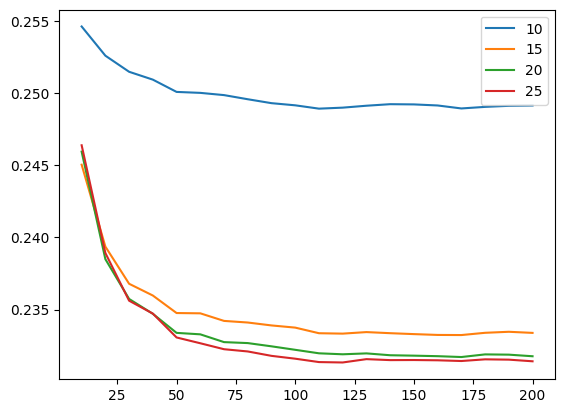

In [42]:
for depth in [10, 15, 20, 25]:
    df_subset = df_rmse_depth[df_rmse_depth['Depth'] == depth]
    plt.plot(df_subset['Estimator'], df_subset['RMSE'], label=depth)

plt.legend()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* **median_income**
* `total_bedrooms`
* `longitude`

In [43]:
model_rf = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [44]:
model_rf.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [46]:
df_importances = pd.DataFrame()
df_importances['feature'] = dict_vect.get_feature_names()
df_importances['importance'] = model_rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False)

/home/elite/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145
10,population,0.030777
12,total_rooms,0.020541
11,total_bedrooms,0.019172
0,households,0.016387
9,ocean_proximity=NEAR OCEAN,0.004699


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* **0.3**
* 0.1
* Both gives same

In [53]:
features = dict_vect.get_feature_names()
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [55]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [79]:
xgb_params_03 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_xgb_results = dict()
model_xgb = xgb.train(xgb_params_03, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist, evals_result=model_xgb_results)

[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.24624
[25]	train-rmse:0.20395	val-rmse:0.24099
[30]	train-rmse:0.19440	val-rmse:0.23741
[35]	train-rmse:0.18637	val-rmse:0.23562
[40]	train-rmse:0.17983	val-rmse:0.23419
[45]	train-rmse:0.17468	val-rmse:0.23279
[50]	train-rmse:0.16934	val-rmse:0.23097
[55]	train-rmse:0.16546	val-rmse:0.23039
[60]	train-rmse:0.16177	val-rmse:0.22950
[65]	train-rmse:0.15762	val-rmse:0.22857
[70]	train-rmse:0.15323	val-rmse:0.22787
[75]	train-rmse:0.15010	val-rmse:0.22755
[80]	train-rmse:0.14564	val-rmse:0.22611
[85]	train-rmse:0.14166	val-rmse:0.22579
[90]	train-rmse:0.13892	val-rmse:0.22628
[95]	train-rmse:0.13553	val-rmse:0.22630
[99]	train-rmse:0.13299	val-rmse:0.22610


In [68]:
df_xgb_results_eta03 = pd.DataFrame(zip(model_xgb_results['train']['rmse'], model_xgb_results['val']['rmse']), columns=['train_rmse', 'val-rmse'])


In [70]:
df_xgb_results_eta03

,train_rmse,val-rmse
0,8.127330,8.132449
1,5.695860,5.700702
2,3.995396,4.000411
3,2.807121,2.810786
4,1.978336,1.981749
...,...,...
95,0.135534,0.226304
96,0.134576,0.226202
97,0.133723,0.226080
98,0.133443,0.226106


In [80]:
xgb_params_01 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_xgb_results = dict()
model_xgb = xgb.train(xgb_params_01, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist, evals_result=model_xgb_results)

[0]	train-rmse:10.44372	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-rmse:2.17500	val-rmse:2.17928
[20]	train-rmse:1.30499	val-rmse:1.31054
[25]	train-rmse:0.79933	val-rmse:0.80657
[30]	train-rmse:0.51144	val-rmse:0.52189
[35]	train-rmse:0.35700	val-rmse:0.37264
[40]	train-rmse:0.27984	val-rmse:0.30053
[45]	train-rmse:0.24350	val-rmse:0.26829
[50]	train-rmse:0.22614	val-rmse:0.25334
[55]	train-rmse:0.21695	val-rmse:0.24657
[60]	train-rmse:0.21035	val-rmse:0.24189
[65]	train-rmse:0.20579	val-rmse:0.23943
[70]	train-rmse:0.20116	val-rmse:0.23684
[75]	train-rmse:0.19680	val-rmse:0.23507
[80]	train-rmse:0.19384	val-rmse:0.23398
[85]	train-rmse:0.19085	val-rmse:0.23275
[90]	train-rmse:0.18794	val-rmse:0.23206
[95]	train-rmse:0.18541	val-rmse:0.23106
[99]	train-rmse:0.18329	val-rmse:0.23054


In [66]:
df_xgb_results_eta01 = pd.DataFrame(zip(model_xgb_results['train']['rmse'], model_xgb_results['val']['rmse']), columns=['train_rmse', 'val-rmse'])
df_xgb_results_eta01

,train_rmse,val-rmse
0,10.443717,10.449375
1,9.401182,9.406841
2,8.462901,8.468309
3,7.618590,7.623911
4,6.858779,6.863676
...,...,...
95,0.185406,0.231057
96,0.184700,0.230895
97,0.184051,0.230675
98,0.183852,0.230572


(0.15, 0.3)

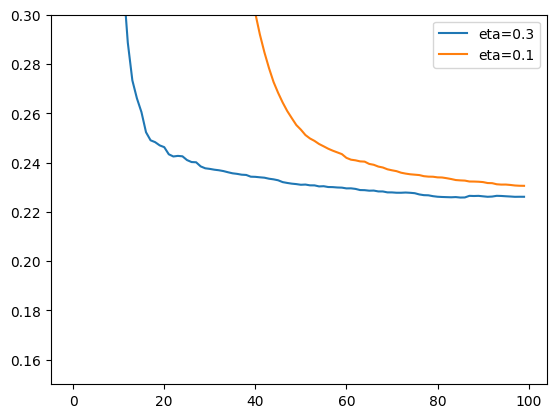

In [78]:
plt.plot(df_xgb_results_eta03['val-rmse'], label='eta=0.3')
plt.plot(df_xgb_results_eta01['val-rmse'], label='eta=0.1')
plt.legend(loc='best')
plt.ylim([0.15, 0.3])


## Submit the results

* Submit your results here: https://forms.gle/3yMSuQ4BeNuZFHTU8
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is 17 October (Monday), 23:00 CEST.

After that, the form will be closed.